# Simple ViT 

In [1]:
pip install -U evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


##### Get data

wat: 700
One Sample


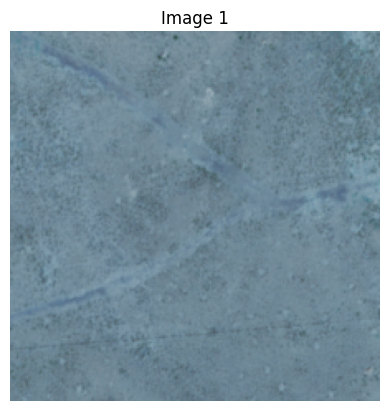

Label: 0
Path: /kaggle/input/fire-risk/train/Very_Low/34411741_1_-109.403495327979_42.6421181109461.png


In [2]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
from torchvision import transforms

data_dir = '/kaggle/input/fire-risk/'


image_paths = []
dataset_type = []
image_labels = []


for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.png'):
            full_path = os.path.join(root, file)
            # Extract parts of the path
            path_parts = full_path.split(os.sep)
            dataset_type.append(path_parts[-3])  # 'train' or 'val'
            image_labels.append(path_parts[-2])  # 'High', 'Low', etc.
            image_paths.append(full_path)


data_df = pd.DataFrame({
    'image_path': image_paths,
    'dataset_type': dataset_type,
    'label': image_labels
})

label_mapping = {
    "Very_Low": 0,
    "Low": 1,
    "Moderate": 2,
    "High": 3,
    "Very_High": 4,
    "Non-burnable": 5,
    "Water": 6
}

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()          
])


class FireRiskDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label_str = self.dataframe.iloc[idx]['label']
        

        image = Image.open(img_path).convert("RGB")
        

        if self.transform:
            image = self.transform(image)
        
        # Map label to numeric value
        label = label_mapping[label_str]
        
        return {'pixel_values': image, 'label': label, 'path': img_path}

train_df = data_df[data_df['dataset_type'] == 'train']
val_df = data_df[data_df['dataset_type'] == 'val']

print(f'wat: {len(val_df)}')

# Create dataset objects for train and validation
train_dataset = FireRiskDataset(train_df, transform=transform)
val_dataset = FireRiskDataset(val_df, transform=transform)

def display_image(img_tensor, index):
    img = img_tensor.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {index + 1}")
    plt.show()


first_sample = train_dataset[0]
print("One Sample")
display_image(first_sample['pixel_values'], 0)  # Display the first image
print(f"Label: {first_sample['label']}")
print(f"Path: {first_sample['path']}")


##### Try to use ViT-B/16 pre-trained on ImageNet1k

Proof that this is what they used: https://github.com/CharmonyShen/FireRisk

Preprocess Data

Load Model

In [3]:

from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments


model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=7, ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train & evaluate model

In [4]:
import numpy as np
import evaluate 

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get the predicted class (highest logit value)


    accuracy_result = accuracy.compute(predictions=predictions, references=labels)
    precision_result = precision.compute(predictions=predictions, references=labels, average="weighted")
    recall_result = recall.compute(predictions=predictions, references=labels, average="weighted")
    f1_result = f1.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy_result["accuracy"],
        "precision": precision_result["precision"],
        "recall": recall_result["recall"],
        "f1": f1_result["f1"],
    }

Print Results

In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np

training_args = TrainingArguments(
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    max_steps=50,
    eval_strategy='no',
    output_dir="./vit-fire-risk-results",
    logging_dir="./logs",
    save_steps=100, 
    use_cpu=False,
    logging_steps=10,
    gradient_accumulation_steps=8
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

predictions = trainer.predict(test_dataset=val_dataset)
results = predictions.metrics  
print(f"Test results: {results}")


pred_labels = np.argmax(predictions.predictions, axis=1)

conf_matrix = confusion_matrix(predictions.label_ids, pred_labels)
class_report = classification_report(predictions.label_ids, pred_labels)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


max_steps is given, it will override any value given in num_train_epochs
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
10,2.057500
20,1.780500
30,1.594000
40,1.676200
50,1.630900


Test results: {'test_loss': 1.5921392440795898, 'test_accuracy': 0.31857142857142856, 'test_precision': 0.3591377007284474, 'test_recall': 0.31857142857142856, 'test_f1': 0.3141164263886281, 'test_runtime': 277.6672, 'test_samples_per_second': 2.521, 'test_steps_per_second': 2.521}
Confusion Matrix:
 [[ 7 60 18  0  3 11  1]
 [ 5 38 34  2 14  7  0]
 [ 1 32 20 11 30  6  0]
 [ 8 23 22  7 37  2  1]
 [ 0 21 44  3 29  0  3]
 [ 2 24  5  1  1 51 16]
 [ 2 16  2  2  3  4 71]]

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.07      0.11       100
           1       0.18      0.38      0.24       100
           2       0.14      0.20      0.16       100
           3       0.27      0.07      0.11       100
           4       0.25      0.29      0.27       100
           5       0.63      0.51      0.56       100
           6       0.77      0.71      0.74       100

    accuracy                           0.32       700
   macro avg    

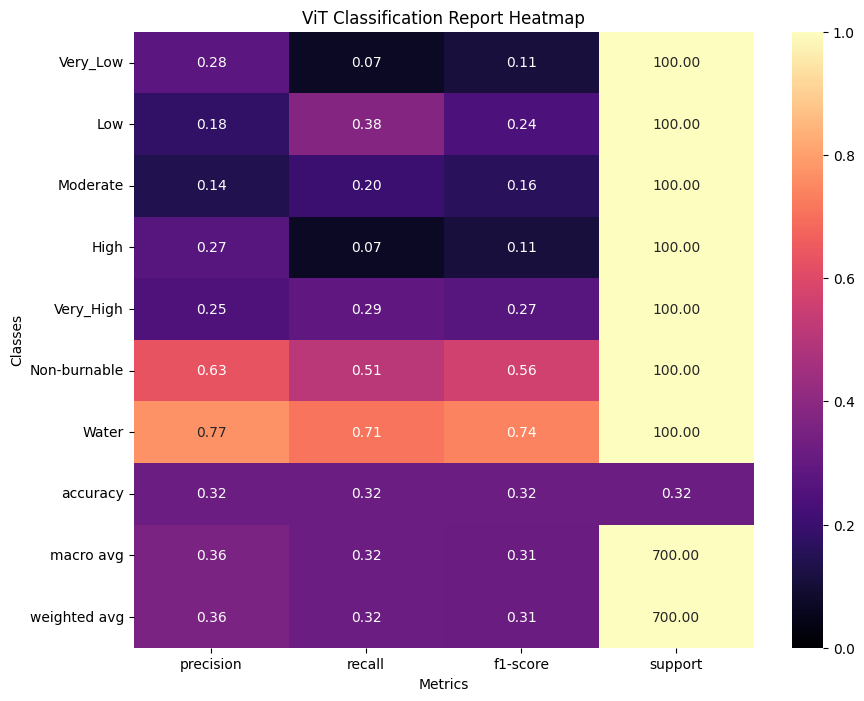

In [7]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_report = classification_report(predictions.label_ids, pred_labels, output_dict=True)
df = pd.DataFrame(class_report).transpose()


label_mapping = {
    0: "Very_Low",
    1: "Low",
    2: "Moderate",
    3: "High",
    4: "Very_High",
    5: "Non-burnable",
    6: "Water"
}


class_labels = [label_mapping[i] for i in range(len(label_mapping))]
df.index = class_labels + ["accuracy", "macro avg", "weighted avg"]


plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap="magma", fmt=".2f", vmin=0, vmax=1)
plt.title("ViT Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

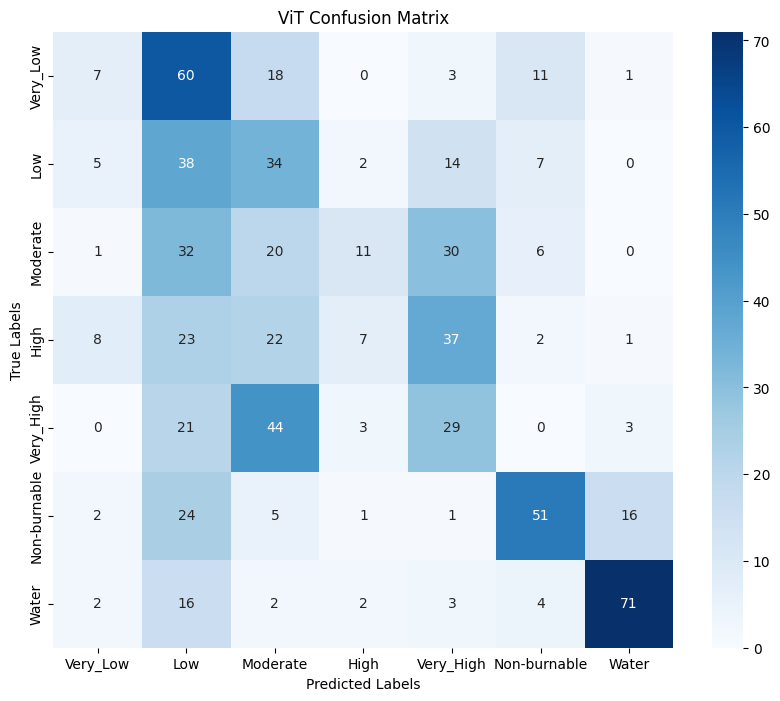

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



conf_matrix = confusion_matrix(predictions.label_ids, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.title("ViT Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Fairlearn metrics

In [13]:
! pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 3.9 MB/s eta 0:00:00a 0:00:01


In [25]:
from fairlearn.metrics import equalized_odds_difference
from sklearn.calibration import calibration_curve
from scipy.special import softmax
import numpy as np

label_mapping = {
    "Very_Low": 0,
    "Low": 1,
    "Moderate": 2,
    "High": 3,
    "Very_High": 4,
    "Non-burnable": 5,
    "Water": 6
}

logits = predictions.predictions
y_true = predictions.label_ids

y_pred_prob_all = softmax(logits, axis=1)  # Probability scores for all classes
y_pred = np.argmax(logits, axis=1)         # Predicted class labels


for label_name in label_mapping.keys():
    # Binary conversion: 1 for the label of interest, 0 for all others
    positive_label = label_mapping[label_name]
    y_true_binary = [1 if label == positive_label else 0 for label in y_true]
    y_pred_binary = [1 if pred == positive_label else 0 for pred in y_pred]
    
    # Define sensitive feature as this label vs. others for fairness evaluation
    sensitive_feature = [label_name if label == positive_label else "Other" for label in y_true]
    
    # Get Equalized Odds Difference for binary classification
    eo_difference = equalized_odds_difference(y_true_binary, y_pred_binary, sensitive_features=sensitive_feature)
    print(f"Equalized Odds Difference for '{label_name}': {eo_difference}")
    
    # Calculate probabilities for the postive laebel
    group_indices = [i for i, label in enumerate(y_true) if label == positive_label]
    group_y_true = [y_true_binary[i] for i in group_indices]
    group_y_prob = [y_pred_prob_all[i][positive_label] for i in group_indices]
    
    # Calculate calibration curve for this group
    prob_true, prob_pred = calibration_curve(group_y_true, group_y_prob, n_bins=10)
    
    # Calculate Expected Calibration Error (ECE) for this group
    ece = np.abs(prob_true - prob_pred).mean()
    print(f"Expected Calibration Error (ECE) for '{label_name}': {ece}")




Equalized Odds Difference for 'Very_Low': 0.07
Expected Calibration Error (ECE) for 'Very_Low': 0.7596721703081336
Equalized Odds Difference for 'Low': 0.38
Expected Calibration Error (ECE) for 'Low': 0.6647511500858471
Equalized Odds Difference for 'Moderate': 0.20833333333333334
Expected Calibration Error (ECE) for 'Moderate': 0.7497160375478347
Equalized Odds Difference for 'High': 0.07
Expected Calibration Error (ECE) for 'High': 0.8509823047516183
Equalized Odds Difference for 'Very_High': 0.29
Expected Calibration Error (ECE) for 'Very_High': 0.7551183793287137
Equalized Odds Difference for 'Non-burnable': 0.51
Expected Calibration Error (ECE) for 'Non-burnable': 0.6000089635633594
Equalized Odds Difference for 'Water': 0.71
Expected Calibration Error (ECE) for 'Water': 0.4910227299421961
